<a href="https://colab.research.google.com/github/alemoorales2/Multiple-logistic-regression-to-create-an-artificial-recommendation-system/blob/main/Sistema_de_recomendacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import random
from collections import Counter
from statistics import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    cross_val_score,
    train_test_split,
    learning_curve
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

# Aplicación a datos lineales

Antes de nada nos preguntamos ¿Qué precisión es razonable esperar?
Para modelos simples con dos variables independientes y una variable de respuesta con 4 clases (multiclase), la precisión base dependerá lógicamente de la complejidad de los datos.

La precisión base o aleatoria sería del 25% si las clases están distribuidas uniformemente (porque hay 4 posibles clases). Cualquier modelo que supere este valor estaría mejorando las predicciones en comparación con una asignación aleatoria.

Modelos bien ajustados podrían lograr precisiones significativamente mayores, del orden del 60%-90% en algunos casos, dependiendo de los factores mencionados.




Entendindo el supuesto de linealidad al trabajar con regresión logística, empecemos a trabajar con un cojunto de datos con cierta linealidad.

In [ ]:
ruta_archivo = '/mnt/datos_1.xlsx'
datos = pd.read_excel(ruta_archivo)
df = pd.DataFrame(datos)

In [ ]:
X = df[['Edad', 'Ingreso']]
y = df['Restaurante']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

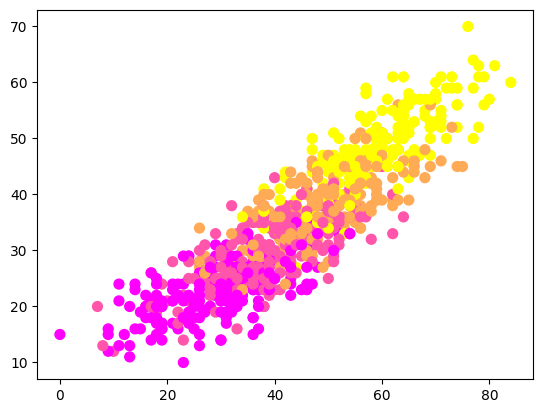

In [ ]:
plt.scatter(np.array(X_train)[:,0], np.array(X_train)[:, 1], s=50, c = np.array(y_train),cmap='spring')

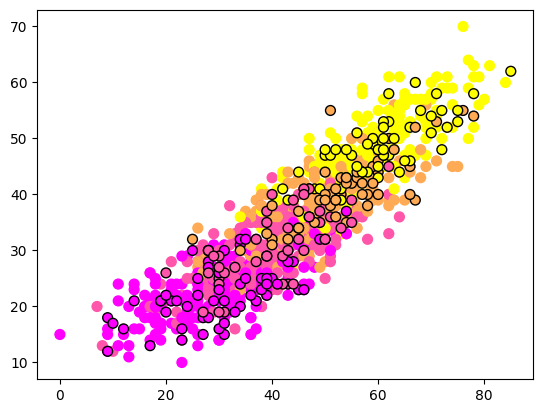

In [ ]:
# Visualizamos cuáles son los elementos test
plt.scatter(np.array(X_train)[:,0], np.array(X_train)[:, 1], s=50, c = np.array(y_train),cmap='spring')
plt.scatter(np.array(X_test)[:, 0], np.array(X_test)[:, 1], s=50, c = np.array(y_test), cmap = 'spring', edgecolors='black')

In [ ]:
# Creamos el modelo de Regresión Logística con múltiples clases (multinomial)
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)
model.fit(X_train_scaled, y_train)

# Realizamos predicciones
y_pred = model.predict(X_test_scaled)

# Evaluamos el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.645


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Podemos mejorar todavia más nuestro modelo de regresión logística

In [ ]:
df = pd.DataFrame(datos)
X = df[['Edad', 'Ingreso']]
y = df['Restaurante']

scaler = StandardScaler().fit(X)

#Escalamos los datos para que cada característica se escala para que tenga media 0 y desviación estándar 1,
#lo que es una práctica común en modelos de machine learning como la regresión logística.

x_scaled = scaler.transform(X)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, random_state=0)

#Ahora procedamos a la busqueda de hiperparametros C: controla la regularización del modelo (valores más altos implican menor regularización).
#tol: el umbral de tolerancia para la convergencia del algoritmo.
params = {'C':[100,10000], 'tol': [0.001,0.0001]}
log_reg = LogisticRegression(solver= 'lbfgs', multi_class = 'multinomial')
clf = GridSearchCV(log_reg, params, scoring='accuracy',refit='True', n_jobs=-1,cv=5) #Vemos cual son los mejores parametros
clf.fit(x_train,y_train) #Entrenamos nuestro nuevo modelo
print("best params:" + str(clf.best_params_)) #Imprimimos los mejores parametros

x_test = scaler.transform(x_test)
y_test = clf.predict_proba(x_test)

#Ahora vamos a utilizar la validación cruzada para evaluar el modelo.
#La función RepeatedStratifiedKFold divide los datos en 10 grupos (n_splits=10) y repite esta división 3 veces (n_repeats=3). De esta manera, el modelo
#se entrena varias veces con diferentes particiones de los datos, lo que proporciona una estimación más estable de la precisión del modelo.

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from statistics import *

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats=3, random_state = 1)
n_scores = cross_val_score(log_reg,x_train,y_train, scoring= 'accuracy', cv = cv, n_jobs = -1) #evalúa el modelo en cada división y devuelve una lista con las precisiones
print('Mean accuaracy: %.3f (%.3f)' %(mean(n_scores), stdev(n_scores))) #calculo la media y la desviacion tipica de esas precisiones

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


best params:{'C': 100, 'tol': 0.0001}
Mean accuaracy: 0.616 (0.052)


Tenemos una precisión media de 61.6% con una desviacion típica de 0.052






Hagamos un ejemplo para nuestro modelo mejorado

In [ ]:
Variable_x1 = 34
Variable_x2 = 22
nuevo_dato = np.array([[Variable_x1, Variable_x2]])
nuevo_dato_escalado = scaler.transform(nuevo_dato)
prediccion = clf.predict(nuevo_dato_escalado)

if prediccion[0] == 1:
    resultado = 'italiano'
elif prediccion[0] == 2:
    resultado = 'español'
elif prediccion[0] == 3:
    resultado = 'asiatico'
else:
    resultado = 'fast food'
print(f"\nEl tipo de restaurante recomendado para una persona de {Variable_x1} años con ingreso {Variable_x2} € es: {resultado}")


El tipo de restaurante recomendado para una persona de 34 años con ingreso 22 € es: italiano


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
X = df[['Edad', 'Ingreso']]
y = df['Restaurante']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

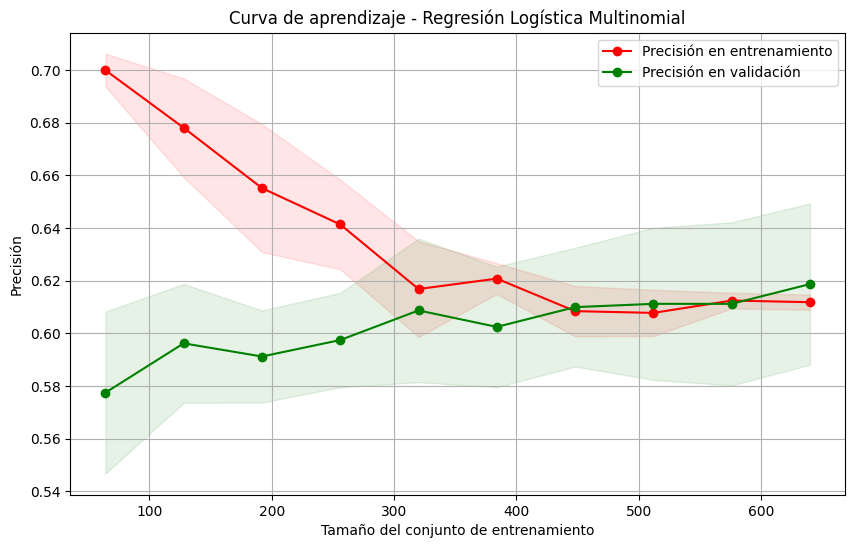

In [ ]:

# Escalar los datos usando pipeline para combinar pasos
model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
])

# Definir las métricas para la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calcular la media y la desviación estándar para cada conjunto de entrenamiento
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Precisión en entrenamiento")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Precisión en validación")

# Sombras para la desviación estándar
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)

plt.title("Curva de aprendizaje - Regresión Logística Multinomial")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Precisión")
plt.legend(loc="best")
plt.grid(True)
plt.show()

En nuestro caso obtendremos una precision de un 62% aproximadamente que nos da una buena predicción teniendo en cuenta nuestros datos


# Aplicación con datos de la encuesta.

Estos datos han sido obtenidos a través de una encuesta realizada por la red social Instagram

In [ ]:
#Ahora veamos un ejemplo donde los datos no son lineales para ver el error
data = {
    'Edad': [21, 34, 21, 58, 56, 58, 23, 21, 43, 24, 23, 28, 22, 22, 37, 27, 23, 23, 31, 25, 24, 21, 29, 28, 21, 32, 29, 32, 23, 24, 33, 22, 22, 44, 26, 35, 18, 19, 20, 21, 32, 34, 33, 30, 22, 24, 27, 23, 23, 23, 41, 23, 23, 22, 24, 23, 21, 23, 23, 24, 23, 24, 21, 22, 20, 21, 22, 25, 26, 27, 26, 25, 26, 24, 24, 24, 27, 22, 23, 23, 30, 33, 31, 22, 23, 23, 22, 21, 60, 58, 44, 49, 70, 72, 78, 80, 69, 54, 43, 47, 55, 58, 63, 48, 26, 28, 30, 23, 24, 23, 23, 23, 23, 23, 28, 23, 32, 23, 33, 25, 30, 24, 24, 30, 23, 40, 24, 23, 58, 27, 26, 26, 23, 22, 28, 23, 21, 24, 23, 24, 28, 25, 45, 52, 38, 22, 27, 23, 26, 21, 25, 25, 23, 28, 31, 29, 23]
,
    'Ingreso': [10, 19, 28, 24, 20, 27, 11, 18, 18, 47, 18, 19, 11, 16, 10, 12, 12, 10, 12, 12, 12, 18, 11, 19, 14, 19, 18, 10, 19, 20, 16, 12, 18, 20, 15, 19, 13, 14, 11, 11, 15, 16, 13, 11, 10, 17, 10, 15, 12, 13, 60, 19, 15, 17, 13, 13, 13, 10, 17, 10, 10, 11, 11, 16, 11, 14, 11, 18, 12, 19, 11, 15, 17, 18, 14, 17, 17, 16, 15, 10, 17, 19, 15, 18, 13, 15, 14, 10, 61, 98, 73, 84, 86, 79, 74, 91, 86, 58, 99, 95, 93, 90, 91, 97, 33, 24, 40, 30, 26, 67, 64, 24, 28, 23, 30, 30, 30, 21, 30, 26, 20, 25, 24, 20, 21, 29, 30, 27, 24, 20, 25, 29, 22, 23, 22, 23, 30, 25, 23, 29, 26, 29, 45, 48, 39, 45, 39, 40, 39, 40, 49, 38, 40, 46, 34, 32, 36]
,
    'Restaurante': [3, 2, 1, 2, 2, 1, 1, 4, 2, 2, 1, 4, 1, 1, 1, 3, 2, 1, 4, 2, 4, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 1, 1, 1, 2, 4, 4, 3, 1, 2, 2, 2, 2, 4, 3, 3, 3, 2, 2, 4, 2, 1, 1, 4, 4, 4, 4, 3, 2, 2, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 2, 2, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 2, 2, 3, 3, 2, 1, 2, 2, 2, 3, 3, 3, 3, 1, 2, 3, 3, 2, 4, 4, 4, 2, 2, 1, 4, 4, 1, 4, 4, 4, 1, 2, 2, 2, 4, 3, 4, 4, 1, 1, 1, 2, 2, 2, 3, 1, 3, 4, 3, 3, 1, 2, 2, 4, 2, 2, 4, 3, 3, 3, 1, 1, 1, 2, 2, 2, 3, 4, 4]
}

# Convertimos los datos en un DataFrame de pandas
df = pd.DataFrame(data)


In [ ]:
# Dividimos las características (Edad e Ingreso_encoded) y la variable objetivo (Restaurante)
X = df[['Edad', 'Ingreso']]
y = df['Restaurante']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.array(X_train)[:,1]


array([30, 13, 21, 13, 24, 13, 18, 27, 18, 23, 15, 39, 13, 17, 11, 22, 26,
       19, 10, 12, 40, 10, 14, 30, 16, 20, 18, 10, 90, 11, 12, 24, 18, 73,
       39, 10, 28, 11, 10, 15, 19, 15, 46, 19, 19, 64, 11, 15, 20, 40, 29,
       15, 23, 11, 18, 20, 33, 21, 11, 79, 86, 17, 27, 67, 39, 13, 19, 17,
       16, 15, 10, 18, 11, 11, 30, 84, 18, 29, 45, 98, 18, 16, 10, 22, 24,
       10, 11, 17, 25, 11, 48, 93, 28, 20, 16, 30, 13, 30, 60, 34, 17, 12,
       61, 18, 10, 38, 20, 14, 40, 19, 15, 25, 97, 95, 30, 10, 14, 25, 36,
       12, 15, 40, 10, 86, 91])

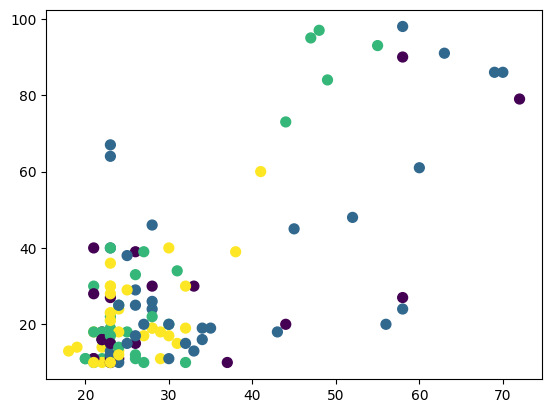

In [ ]:
plt.scatter(np.array(X_train)[:,0], np.array(X_train)[:, 1], s=50, c = np.array(y_train))

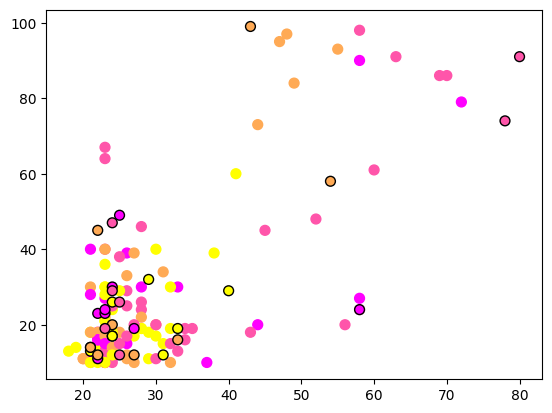

In [ ]:
# Visualizamos cuáles son los elementos test
plt.scatter(np.array(X_train)[:,0], np.array(X_train)[:, 1], s=50, c = np.array(y_train),cmap='spring')
plt.scatter(np.array(X_test)[:, 0], np.array(X_test)[:, 1], s=50, c = np.array(y_test), cmap = 'spring', edgecolors='black')

In [ ]:
# Creamos el modelo de Regresión Logística con múltiples clases (multinomial)
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# Realizamos predicciones
y_pred = model.predict(X_test)

# Evaluamos el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))




Accuracy: 0.25


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Aqui podemos ver que nuestra precisión es baja debido seguramente debido a varias razones como: mala distribucción de los datos, leve cantidad de los mismos, mala elección de los datos de train... que podemos arreglar de varias formas, haciendo una encuesta de datos más equilibrada, validación cruzada...
Después veremos que efectivamente es por la baja linealidad de los datos

Observamos que en efecto no estan del todo balanceados

In [ ]:
print(Counter(X_train['Edad']))

Counter({23: 31, 21: 9, 22: 9, 24: 9, 26: 8, 28: 7, 30: 5, 25: 4, 27: 4, 32: 4, 58: 4, 33: 2, 29: 2, 34: 2, 44: 2, 20: 2, 31: 2, 18: 1, 56: 1, 38: 1, 72: 1, 69: 1, 35: 1, 49: 1, 45: 1, 43: 1, 52: 1, 55: 1, 41: 1, 60: 1, 19: 1, 48: 1, 47: 1, 37: 1, 70: 1, 63: 1})


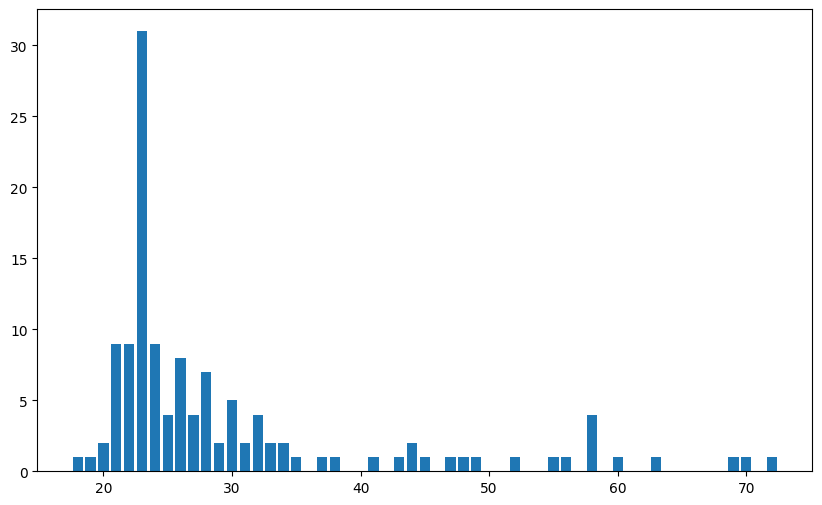

In [ ]:
conteo = {23: 31, 21: 9, 22: 9, 24: 9, 26: 8, 28: 7, 30: 5, 25: 4, 27: 4, 32: 4, 58: 4, 33: 2, 29: 2, 34: 2, 44: 2, 20: 2, 31: 2, 18: 1, 56: 1, 38: 1, 72: 1, 69: 1, 35: 1, 49: 1, 45: 1, 43: 1, 52: 1, 55: 1, 41: 1, 60: 1, 19: 1, 48: 1, 47: 1, 37: 1, 70: 1, 63: 1}
keys = list(conteo.keys())
values = list(conteo.values())
plt.figure(figsize=(10,6))
plt.bar(keys, values)
plt.show()


Veamos la curva de aprendizaje que estudia si variará mucho nuestro resultado con más datos

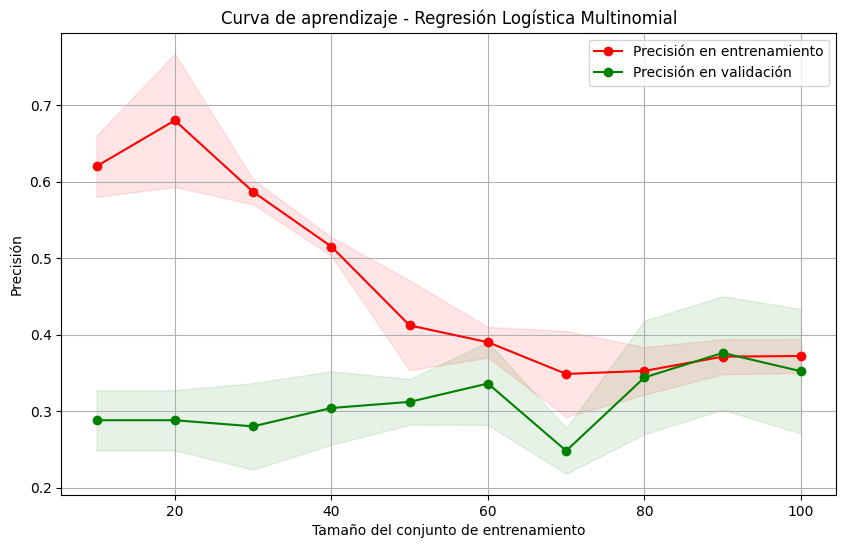

In [ ]:

# Escalar los datos usando pipeline para combinar pasos
model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
])

# Definir las métricas para la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calcular la media y la desviación estándar para cada conjunto de entrenamiento
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Precisión en entrenamiento")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Precisión en validación")

# Sombras para la desviación estándar
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)

plt.title("Curva de aprendizaje - Regresión Logística Multinomial")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Precisión")
plt.legend(loc="best")
plt.grid(True)
plt.show()



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



El tipo de restaurante recomendado para una persona de 34 años con ingreso 22 € es: español


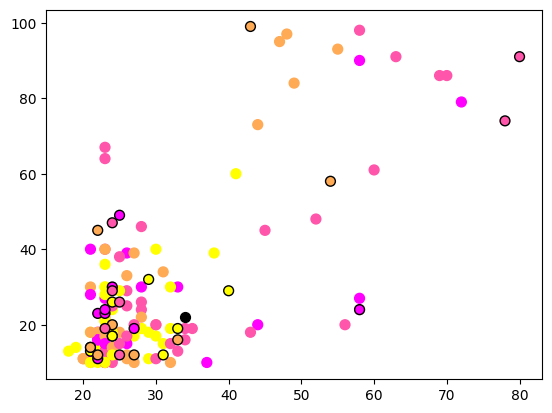

In [ ]:
# Ejemplo de predicción para un nuevo usuario
X = df[['Edad', 'Ingreso']]
y = df['Restaurante']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

Variable_x1 = 34
Variable_x2 = 22

plt.scatter(np.array(X_train)[:,0], np.array(X_train)[:, 1], s=50, c = np.array(y_train),cmap='spring')
plt.scatter(np.array(X_test)[:, 0], np.array(X_test)[:, 1], s=50, c = np.array(y_test), cmap = 'spring', edgecolors='black')
plt.scatter(Variable_x1,Variable_x2,s=50, c = 'black')
new_example = pd.DataFrame([[Variable_x1, Variable_x2]], columns=['Edad', 'Ingreso'])
# Escalar las características para que coincidan con la escala de los datos de entrenamiento

# Usar el modelo para hacer una predicción
prediction = model.predict(new_example)

if prediction[0] == 1:
    resultado = 'italiano'
elif prediction[0] == 2:
    resultado = 'español'
elif prediction[0] == 3:
    resultado = 'asiatico'
else:
    resultado = 'fast food'
print(f"\nEl tipo de restaurante recomendado para una persona de {Variable_x1} años con ingreso {Variable_x2} € es: {resultado}")

# Aplicación con datos no lineales para estudiar la convergencia

Ahora haremos una predicción con una gran cantidad de datos generados por chat gpt, para ver que la precisión converge ciertamente a lo que hemos visto

In [ ]:
ruta_archivo = '/mnt/datos_2.xlsx'
datos = pd.read_excel(ruta_archivo)
df = pd.DataFrame(datos)


In [ ]:
X = df[['Edad', 'Ingreso']]
y = df['Restaurante']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=32)


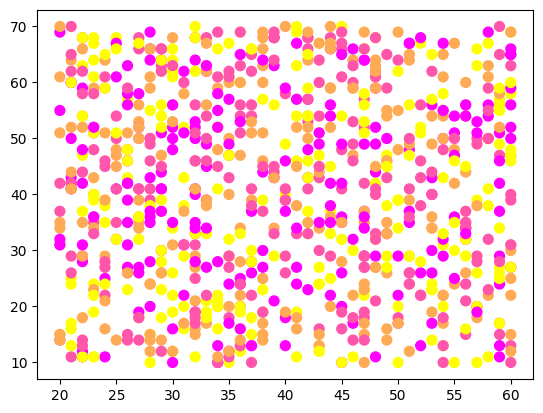

In [ ]:
plt.scatter(np.array(X_train)[:,0], np.array(X_train)[:, 1], s=50, c = np.array(y_train),cmap='spring')

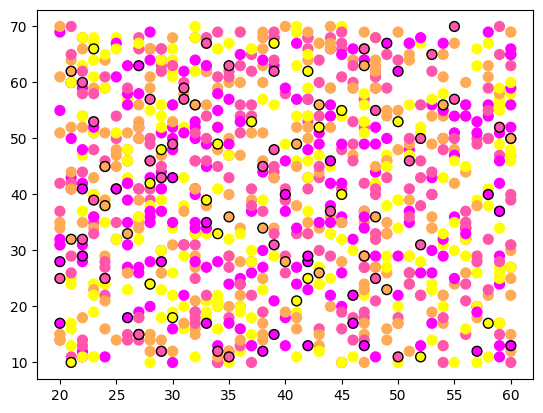

In [ ]:
# Visualizamos cuáles son los elementos test
plt.scatter(np.array(X_train)[:,0], np.array(X_train)[:, 1], s=50, c = np.array(y_train),cmap='spring')
plt.scatter(np.array(X_test)[:, 0], np.array(X_test)[:, 1], s=50, c = np.array(y_test), cmap = 'spring', edgecolors='black')

In [ ]:
# Creamos el modelo de Regresión Logística con múltiples clases (multinomial)
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)
model.fit(X_train_scaled, y_train)

# Realizamos predicciones
y_pred = model.predict(X_test_scaled)

# Evaluamos el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.31


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
#Veamos si nos da el mismo valor con estos datos
Variable_x1 = 34
Variable_x2 = 22
new_example = pd.DataFrame([[Variable_x1, Variable_x2]], columns=['Edad', 'Ingreso'])
prediction = model.predict(new_example)

if prediction[0] == 1:
    resultado = 'italiano'
elif prediction[0] == 2:
    resultado = 'español'
elif prediction[0] == 3:
    resultado = 'asiatico'
else:
    resultado = 'fast food'
print(f"\nEl tipo de restaurante recomendado para una persona de {Variable_x1} años con ingreso {Variable_x2} € es: {resultado}")


El tipo de restaurante recomendado para una persona de 34 años con ingreso 22 € es: italiano


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Usaremos un código que hemos diseñado para ver si el problema esta en que necesitaremos otra distribucción de las variables para el uso de este modelo

In [ ]:
df = pd.DataFrame(datos)
X = df[['Edad', 'Ingreso']]
y = df['Restaurante']

scaler = StandardScaler().fit(X)

x_scaled = scaler.transform(X)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, random_state=0)
params = {'C':[100,10000], 'tol': [0.001,0.0001]}
log_reg = LogisticRegression(solver= 'lbfgs', multi_class = 'multinomial')
clf = GridSearchCV(log_reg, params, scoring='accuracy',refit='True', n_jobs=-1,cv=5)#Calcula los parametros para mejorar la precisión
clf.fit(x_train,y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


GridSearchCV(cv=5, estimator=LogisticRegression(multi_class='multinomial'),
             n_jobs=-1, param_grid={'C': [100, 10000], 'tol': [0.001, 0.0001]},
             refit='True', scoring='accuracy')

In [ ]:
print("best params:" + str(clf.best_params_))

best params:{'C': 100, 'tol': 0.001}


In [ ]:
x_test = scaler.transform(x_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
y_test = clf.predict_proba(x_test)


In [ ]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats=3, random_state = 1)
n_scores = cross_val_score(log_reg,x_train,y_train, scoring= 'accuracy', cv = cv, n_jobs = -1)
print('Mean accuaracy: %.3f (%.3f)' %(mean(n_scores), stdev(n_scores)))

Mean accuaracy: 0.268 (0.036)


Aqui vemos claramente que el error no esta en la elección del conjunto train, ni en la tolerancia ni nada parecido. Simplemente el algoritmo de regresión depende en gran medida del supuesto de linealidad de los datos, lo que es lógico si comprendemos el modelo matemático que tiene detrás.

# Introducción de una nueva variable

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precisión del modelo: 96.00%


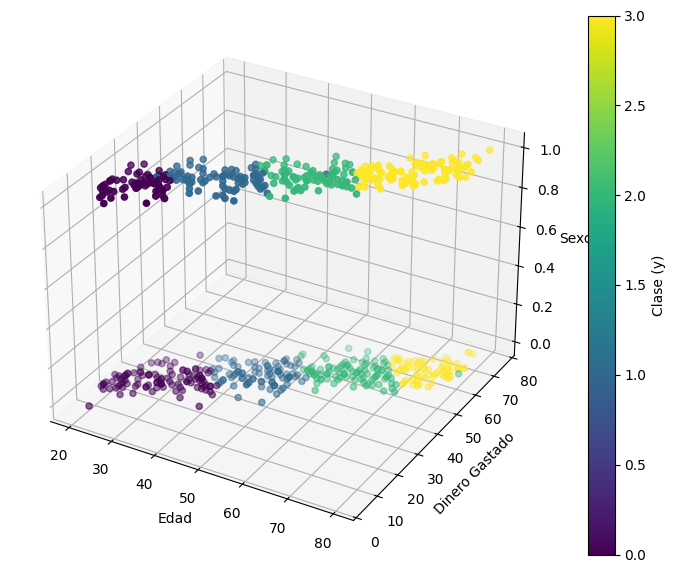

In [ ]:
# Cargar los datos desde el archivo Excel con anomalías
file_path = '/mnt/datos_3.xlsx'  # Actualiza esta ruta con la ubicación correcta
data = pd.read_excel(file_path)

# Dividir en características (X) y etiquetas (y)
X = data[['Edad', 'Dinero_Gastado', 'Sexo']]
y = data['y']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ajustar el modelo de regresión logística multinomial
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Mostrar la precisión y el reporte de clasificación
accuracy = accuracy_score(y_test, y_pred)

print(f"Precisión del modelo: {accuracy * 100:.2f}%")

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Usar las tres variables como coordenadas
sc = ax.scatter(X_train['Edad'], X_train['Dinero_Gastado'], X_train['Sexo'], c=y_train, cmap='viridis')

# Añadir etiquetas de los ejes
ax.set_xlabel('Edad')
ax.set_ylabel('Dinero Gastado')
ax.set_zlabel('Sexo')

# Añadir una barra de colores para representar las clases
plt.colorbar(sc, ax=ax, label='Clase (y)')

# Mostrar la gráfica
plt.show()

In [ ]:
Variable_x1 = 34
Variable_x2 = 22
Variable_x3 = 0
nuevo_dato = np.array([[Variable_x1, Variable_x2, Variable_x3]])
prediccion = model.predict(nuevo_dato)

if prediccion[0] == 0:
    resultado = 'italiano'
elif prediccion[0] == 1:
    resultado = 'español'
elif prediccion[0] == 2:
    resultado = 'asiatico'
else:
    resultado = 'fast food'
print(f"\nEl tipo de restaurante recomendado para una mujer de {Variable_x1} años con ingreso {Variable_x2} € es: {resultado}")


El tipo de restaurante recomendado para una mujer de 34 años con ingreso 22 € es: italiano


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


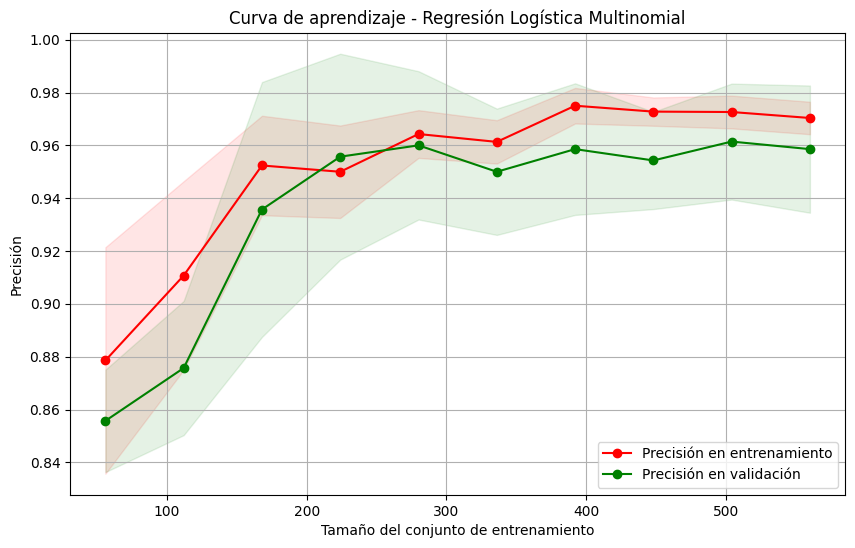

In [ ]:
# Dividir en características (X) y etiquetas (y)
X = data[['Edad', 'Dinero_Gastado', 'Sexo']]
y = data['y']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Definir el pipeline con estandarización y regresión logística multinomial
model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
])

# Definir las métricas para la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calcular la media y la desviación estándar para cada conjunto de entrenamiento
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Precisión en entrenamiento")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Precisión en validación")

# Sombras para la desviación estándar
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)

plt.title("Curva de aprendizaje - Regresión Logística Multinomial")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Precisión")
plt.legend(loc="best")
plt.grid(True)
plt.show()
